# Plots for paper on audience stuff, not analysis.

tidy results please, on figure at a time

In [152]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d
import imageio

from scipy.signal import find_peaks

pd.options.mode.chained_assignment = None

In [153]:
general_loc = '/Users/finn/Desktop/Current_Projects/Copen/'
internal_Part = general_loc + 'Participants_internal/'

public_mlmotion = general_loc + 'Public_data/Motion_ML/'
public_ax3 = general_loc +  'Public_data/Motion_AX3/'
public_Part = general_loc + 'Public_data/Participants/'
public_time = general_loc + 'Public_data/Timing/'

In [154]:
partDets = pd.read_csv(internal_Part + 'Audience_Mapping_Internal.csv')#,index_col = 0,header_col = 0)
# need only in person participants so cut to those in attendence with seats assinged
partDets = partDets.loc[~partDets['X'].isna(),:]
MovingParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements

Part_Codes = list(MovingParts.Participant_Code.values)

In [155]:
claps_folder = './Data/new_indexp/clapping_peaks/' '
#os.listdir(claps_folder)
Applause_ints=pd.read_csv('Clapping_rounds.csv') # generated in next section

In [174]:
claps_folder = './Data/re_claps_paper/clapping_peaks/' # corrected ranges same thr as memis
#os.listdir(claps_folder)
Applause_ints=pd.read_csv('Clapping_rounds_stats.csv') # generated in next section

In [176]:
Applause_ints.columns

Index(['Unnamed: 0', 'start_time', 'end_time', 'duration', 'start_datetime',
       'Type', 'Texture', 'Applause_N', 'cue_start_time', 'cue_start_type',
       'cue_time2start', 'cue_end_time', 'cue_end_type', 'cue_time2end',
       'stage_next_time', 'stage_next_type', 'stage_next_time2', 'files',
       'links', 'Links_time(s)', 'Vid_times', 'Links_ctime(s)',
       'Ratio clapping', 'Median number of Claps', 'STD number of Claps',
       'Median ICI Median', 'Median ICI STD', 'STD ICI Median', 'STD ICI STD',
       'Starting ICI Median', 'Starting ICI STD', 'Starting ICI Quart',
       '5s Med ICI Median', '5s Med ICI STD', '5s quart ICI Median',
       '5s quart ICI STD', 'Firstclap_qrt', 'Lastclap_qrt'],
      dtype='object')

In [172]:
Applause_ints.loc[:,['start_time','event_tag','duration','Ratio clapping','Median ICI Median',]]

,start_time,end_time,duration,start_datetime,Type,Type_M,Texture,event_tag,Applause_N,cue_start_time,...,cue_end_type,cue_time2end,stage_next_time,stage_next_type,stage_next_time2,files,links,Links_time(s),Vid_times,Links_ctime(s)
0,-688.4,-672.4,16.0,2021-10-26 17:36:37.600,Entrance,Other,Independent,Entre 1,1,-689.4,...,Musician toward mic,2.0,-670.4,Start to speak,-2.0,Applause_1_entre_1_peaks.csv,https://youtu.be/S4UVJybA6ZQ?t=1294,1294,0,-692
1,-553.4,-546.4,7.0,2021-10-26 17:38:52.600,Speech,Other,Independent,Speech 1,2,-554.4,...,MC at Mic,3.0,-547.4,MC starts talking,1.0,Applause_2_speech_1_peaks.csv,https://youtu.be/S4UVJybA6ZQ?t=1430,1430,25,-556
2,33.6,42.6,9.0,2021-10-26 17:48:39.600,Speech,Other,Independent,Speech 2,3,33.6,...,Violinist pick up instrument,2.0,40.6,Violinist pick up instrument,2.0,Applause_3_speech_2_peaks.csv,https://youtu.be/S4UVJybA6ZQ?t=2018,2018,41,32
3,1613.6,1654.6,41.0,2021-10-26 18:14:59.600,Music,Music,Mixed,Beethoven,4,1612.6,...,MC starts talking,10.0,1644.6,MC starts talking,10.0,Applause_4_beethoven_peaks.csv,https://youtu.be/S4UVJybA6ZQ?t=3596,3596,57,1610
4,2009.6,2019.6,10.0,2021-10-26 18:21:35.600,Entrance,Other,Independent,Entre 2,5,2009.6,...,Begin to sit down,2.0,2017.6,Begin to sit down,2.0,Applause_5_entre_2_peaks.csv,https://youtu.be/S4UVJybA6ZQ?t=3990,3990,107,2004
5,3285.6,3345.6,60.0,2021-10-26 18:42:51.600,Music,Music,Mixed,Schnittke,6,3283.6,...,Start to leave stage,6.0,3345.6,Off stage,0.0,Applause_6_schnittke_peaks.csv,https://youtu.be/S4UVJybA6ZQ?t=5251,5251,127,3265
6,5005.6,5021.6,16.0,2021-10-26 19:11:31.600,Entrance,Other,Independent,Entre 3,7,5005.6,...,Begin to sit down,3.0,5022.6,MC starts talking,-1.0,Applause_7_entre_3_peaks.csv,https://youtu.be/S4UVJybA6ZQ?t=6990,6990,212,5004
7,6022.6,6044.6,22.0,2021-10-26 19:28:28.600,Music,Music,Independent,Bach,8,6020.6,...,MC at mic,1.0,6044.6,MC starts talking,0.0,Applause_8_bach_peaks.csv,https://youtu.be/S4UVJybA6ZQ?t=7996,7996,237,6010
8,6761.6,6778.6,17.0,2021-10-26 19:40:47.600,Music,Music,Independent,Folk 1,9,6759.6,...,Violinist ready to play,2.0,6779.6,Violinist plays,-1.0,Applause_9_folk_1_peaks.csv,https://youtu.be/S4UVJybA6ZQ?t=8741,8741,273,6755
9,6935.6,6955.6,20.0,2021-10-26 19:43:41.600,Music,Music,Independent,Folk 2,10,6934.6,...,Violinist at mic,7.0,6955.6,Violinist begins to speak,0.0,Applause_10_folk_2_peaks.csv,https://youtu.be/S4UVJybA6ZQ?t=8918,8918,303,6932


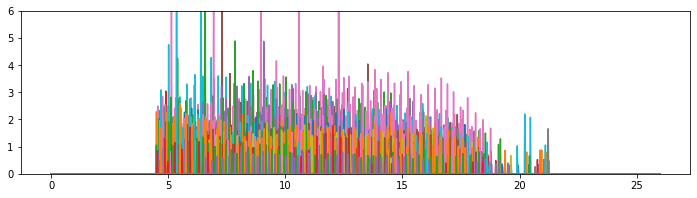

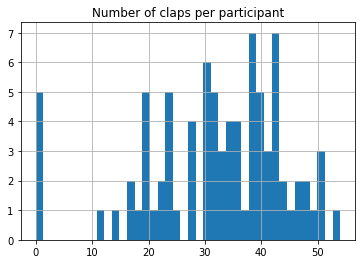

In [173]:
# Example of steps
app_int = 0
# peaks = pd.read_csv(claps_folder + Applause_ints.loc[app_int,'files']+'_peaks.csv',index_col=0)

peaks = pd.read_csv(claps_folder + Applause_ints.loc[app_int,'files'],index_col=0)
peaks.index=(pd.to_datetime(peaks.index))
peaks = peaks.fillna(0)
peaks_IDs = peaks.columns
ts = pd.Series(np.arange(0,len(peaks))*0.02)
df_claps = pd.DataFrame(index = ts,columns = peaks_IDs,data = peaks.values)
df_claps.plot(figsize = [12,3],legend = False)
plt.ylim([0,6])
plt.show()

# drop the clap amplitude for simpler analysis and count claps per participant
df_OnlyClaps = df_claps.astype(bool).astype(int)
df_OnlyClaps.sum().hist(bins = 40)
plt.title('Number of claps per participant')
plt.show()

In [6]:
partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
# need only in person participants with aligned motion traces
partDets = partDets.loc[partDets['Attendance'] == 'A',:] # in person hall participant
alignedParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
aligned_Part_Codes = list(alignedParts.Participant_Code.values)

applause_times = pd.read_csv('data/Applause_Moments.csv',sep=",") #SV alignment for beeps

# set the sampling period for the concert in UTC 
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)

# concert times 50 Hz
ts_ct = np.arange(-1086,9715, 0.02)*1000 
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')


concert_times = pd.read_csv(public_time +'Concert_Events_On_Off.csv',sep=",") #SV alignment for beeps
concert_times['sequence'] = concert_times.index
concert_times.set_index('Time_dt_Start',inplace = True)
concert_times.iloc[:5]

concert_applause = concert_times.loc[concert_times['Event_Type']=='Applause',:]
# music preceding Claps 4, 6, 8, 10-15

df_clappings = pd.DataFrame(columns = ['section_id','start_time_concert','start_time','end_time_concert','end_time','tag','clapping_type'])
tags = ['Concert begins','Clapping Between Speeches 1','Clapping After Introduction','Beethoven Applause','Musicians Return 1','Schnittke Applause','Musicians Return 2','Bach Applause','Folk Music 1 Applause','Folk Music 2 Applause','Folk Music 3 Applause','Folk Music 4 Applause','Folk Music 5 Applause','Clapping Between Speeches 2','Final Applause']
# cue_tags = ['Musicians Enter Hall','Last word','Last word','Last Note' ]
# cue_time = [-694.50,-558.24,29.46,1607.21,]
df_clappings['section_id'] = range(len(tags))
df_clappings['start_time_concert'] = concert_applause['Time_s_Start'].values
df_clappings['start_time'] = concert_applause['Time_Stream_Start'].values
df_clappings['end_time_concert'] = concert_applause['Time_s_End'].values
df_clappings['end_time'] = concert_applause['Time_Stream_End'].values
df_clappings['tag'] = tags
df_clappings['clapping_type'] = [1,1,1,2,1,2,1,2,3,3,3,3,3,1,4]

concert_times = pd.read_csv(public_time +'Concert_Events_On_Off.csv',sep=",") #SV alignment for beeps
concert_times['sequence'] = concert_times.index
concert_times.set_index('Time_dt_Start',inplace = True)
# concert_times.iloc[15:25]
# concert_applause = 
concert_times.loc[concert_times['Event_Type']=='Applause',:]

,Event,Time_s_Start,Time_ms_Start,Time_Stream_Start,Time_dt_End,Time_s_End,Time_ms_End,Time_Stream_End,sequence,Event_Duration,Event_Type
Time_dt_Start,,,,,,,,,,,
2021-10-26 17:36:32.760,Claps 1,-693.24,-693240.0,946.00,2021-10-26 17:36:49.840,-676.16,-676160.0,963.08,0,17.08,Applause
2021-10-26 17:38:47.960,Claps 2,-558.04,-558040.0,1081.20,2021-10-26 17:38:55.880,-550.12,-550120.0,1089.12,2,7.92,Applause
2021-10-26 17:48:34.440,Claps 3,28.44,28440.0,1667.68,2021-10-26 17:48:44.360,38.36,38360.0,1677.60,5,9.92,Applause
2021-10-26 18:14:54.520,Claps 4,1608.52,1608520.0,3247.76,2021-10-26 18:15:35.880,1649.88,1649880.0,3289.12,10,41.36,Applause
2021-10-26 18:21:28.680,Claps 5,2002.68,2002680.0,3641.92,2021-10-26 18:21:40.460,2014.46,2014460.0,3653.70,13,11.78,Applause
2021-10-26 18:42:46.540,Claps 6,3280.54,3280540.0,4919.78,2021-10-26 18:43:46.980,3340.98,3340980.0,4980.22,17,60.44,Applause
2021-10-26 19:11:25.900,Claps 7,4999.90,4999900.0,6639.14,2021-10-26 19:11:43.560,5017.56,5017560.0,6656.80,20,17.66,Applause
2021-10-26 19:28:23.660,Claps 8,6017.66,6017660.0,7656.90,2021-10-26 19:28:45.780,6039.78,6039780.0,7679.02,24,22.12,Applause
2021-10-26 19:40:43.040,Claps 9,6757.04,6757040.0,8396.28,2021-10-26 19:41:00.540,6774.54,6774540.0,8413.78,29,17.50,Applause


In [9]:
def rms_signal(data, window_size, shift):
  # data is pandas Series of signal
  # function to calculate root mean square using a scrolling window.
  i = int(window_size/2)
  l = data.shape[0]
  rms_y = [np.nan]*l

  while True:
    if i >= l:
      break

    if (i >= window_size/2) and (l-i >= window_size/2):
      in_window  = int(i-window_size/2)
      out_window = int(i+window_size/2)

      data_rms = data.iloc[in_window:out_window]
      if data_rms.isna().sum() < (len(data_rms)):
        data_rms = data_rms.dropna()
      rms_value = math.sqrt(sum([i*i for i in data_rms])/len(data_rms)) if data_rms.isna().sum() == 0 else -1

    else:
      rms_value = np.nan

    rms_y[i] = rms_value
    i = i + shift

  df = pd.DataFrame(index = data.index, columns = ['rms'], data={'rms': rms_y})
  return df

def butter_lowpass_filter(data, cutoff, fs, order):
  normal_cutoff = cutoff / nyq
  b, a = butter(order, normal_cutoff, btype='low', analog=False)
  y = filtfilt(b, a, data)
  return y

# NEW NO PD APPEND
def gap_nans(data,gap_t):
    # data is a pandas dataframe with columns called time and/or time_concert which is used to ID gaps greater than gap_T
    # gap_T is in milliseconds (ms)
    # rows of NaN data is added to non-time columns before the first sample, at edges of each gap, and after the last sample of data
    # these nans prevent interpolation errors through missing data
    cols = data.columns
    if 'time' in cols:
        time_col = 'time'
    if 'time_concert' in cols:
        time_col = 'time_concert'
        
    deltat = round(0.35*data[time_col].diff().median())
    dtdeltat =  pd.to_timedelta(deltat,unit = 'ms')
    dt = data[time_col].diff()    
    gapsi = np.array(dt[dt>gap_t].index)
    a = np.append(gapsi-1,dt.index[-1])
    gapsd = pd.DataFrame(index = a,columns = data.columns)
    for c in cols:
        if c.startswith('datetime'):
            gapsd[c] = data.loc[a,c]+dtdeltat
        if c.startswith('time'):
            gapsd[c] = data.loc[a,c]+deltat 

    a = np.append(gapsi,dt.index[0])
    gapsp = pd.DataFrame(index = a,columns = data.columns)
    for c in cols:
        if c.startswith('datetime'):
            gapsp[c] = data.loc[a,c]-dtdeltat
        if c.startswith('time'):
            gapsp[c] = data.loc[a,c]-deltat 

    data = pd.concat([gapsp,gapsd,data]).sort_values(time_col,ignore_index=True)
    return data

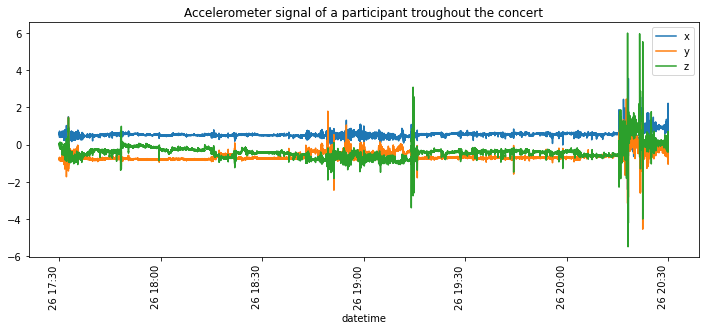

In [102]:
# i = 11
# participant = alignedParts.loc[i,:]

part = 'AER090'#participant['Participant_Code']
if part[2]=='Q': # Motionlab phone acc
    inst_d = pd.read_csv(public_mlmotion + part + '_Mobile_Motion.csv' )
else: # AX3
    inst_d = pd.read_csv(public_ax3 + part + '_AX3_Motion.csv' )
inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format


inst_d.plot(x='datetime', y=['x','y','z'], figsize=(12,4.8), title='Accelerometer signal of a participant troughout the concert')
plt.xticks(rotation=90)
plt.show()

In [103]:
# transfer to a consistent samples rate
aud_df = pd.DataFrame(index = ts_ct)
kept_dev = []
gap_t = 100
datas = gap_nans(inst_d,gap_t)
#get concert time
resampled = pd.DataFrame(index = ts_ct)
cols = datas.columns
for col in cols[1:]:
    f = interp1d(datas['time'], datas[col],fill_value='extrapolate')
    resampled[col] = f(ts_ct)

# extract 1D accelerometer feature for easy comparison
# and basic normalisation
b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
if part[2]=='Q':
    aud_df[part] = b
else:
    aud_df[part] = b*8
aud_df.index = dt_ct

full_motion_50hz_df = aud_df.copy()
full_motion_50hz_df.index = ts_ct

In [104]:
ts_ct

array([-1086000.        , -1085980.        , -1085960.        , ...,
        9714939.99999018,  9714959.99999018,  9714979.99999018])

In [150]:
#for ev_idx in df_clappings['section_id']:
ev_idx = 0
ev_in, ev_out, ev_type, ev_tag = df_clappings.loc[ev_idx, ['start_time_concert', 'end_time_concert', 'clapping_type', 'tag']]

# low pass filter
T = 10.0        # sample period
fs = 50.0       # Hz
cutoff = 12.5   # cutoff frequency of the filter # Hz
nyq = 0.5 * fs  # nyquist frequency
order = 2 
n = int(T * fs)


extend = 0
in_event_time = (ev_in - extend) * 10**3
out_event_time = (ev_out + extend) * 10**3
   
df_seg = full_motion_50hz_df.loc[in_event_time:out_event_time]
df_seg_ind = np.round(df_seg.index) 
print('section:', ev_tag, (in_event_time, out_event_time),len(df_seg))

ts_ev = np.round(df_seg.index - df_seg.index[0]) # not in date time for now, just ms
df_section = pd.DataFrame(index = ts_ev,columns = aud_df.columns)
for dev_n in df_seg.columns:
    #print('   ', dev_n)
    df_clap = df_seg.loc[:,dev_n]
    data_raw = df_clap[~np.isnan(df_clap)]
    if data_raw.shape[0] > 10:
        data_filtered = butter_lowpass_filter(data_raw, cutoff, fs, order)
    else:
        #data_raw[f.split('.')[0]] = np.nan
        data_filtered = data_raw
df_clap.loc[data_raw.index] = data_filtered
# save clapping interval as df
df_section[dev_n] = df_clap.values
df_section.index = pd.to_datetime(df_section.index, unit='ms').strftime('%H:%M:%S.%f')
#df_section.index = pd.to_datetime(df_seg_ind, unit='ms').strftime('%H:%M:%S.%f')
df_section.index.name = 'index'
df_section

section: Concert begins (-693240.0, -676160.0) 854


,AER090
index,
00:00:00.000000,0.153264
00:00:00.020000,0.127635
00:00:00.040000,0.146119
00:00:00.060000,0.191836
00:00:00.080000,0.217949
...,...
00:00:16.980000,0.171244
00:00:17.000000,0.167856
00:00:17.020000,0.189893


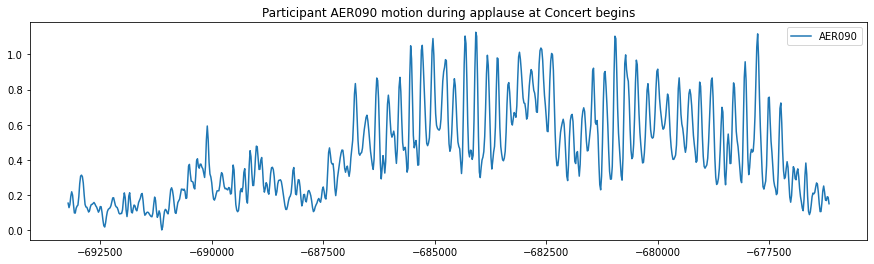

In [151]:
df_seg.plot(figsize=[15,4])
plt.title('Participant ' + part + ' motion during applause at ' + ev_tag)
plt.show()

0.2584889263753414


<AxesSubplot:>

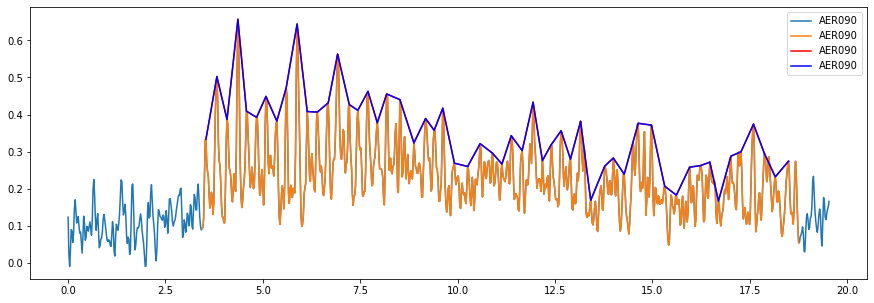

In [122]:
df_motion =df_section.copy()
df_motion.index = pd.Series(np.arange(0,len(df_motion.index))*0.02)
df_ev = df_motion.copy()

# create csv files
df_trimmed = pd.DataFrame(index=df_ev.index)
df_peaks = pd.DataFrame(index=df_ev.index, columns=df_ev.columns)


col = part
fs = 50
extend_ind = 4*fs
extend = 0.1
seg_len=len(df_motion)

fig,ax = plt.subplots(1,1,figsize=[15,5])
df_ev.plot(ax=ax)
# # create csv files
# df_trimmed = pd.DataFrame(index=df_ev.index)
# df_peaks = pd.DataFrame(index=df_ev.index, columns=df_ev.columns)

rms = rms_signal(df_motion[part], fs, 4).dropna().replace(-1,np.nan)
std = np.std(df_ev[col])
thr = rms.mean()[0] + std*0.35
thr = 0 if np.isnan(thr) else thr
std_thr = 0.08
# discard if std of signal is below std_thr
thr = 0 if std<=std_thr else thr

print(thr)
if not (thr == 0):
    in_  = df_ev[df_ev[col]>thr][col].index.values[ 0] - extend
    out_ = df_ev[df_ev[col]>thr][col].index.values[-1] + extend
else:
    in_  = 0
    out_ = 0
df_ev.loc[:in_,col] = np.nan
df_ev.loc[out_:,col] = np.nan

df_ev.plot(ax=ax)
peak_index_list = find_peaks(df_ev[col].values,distance=10)[0]
df_ev.iloc[peak_index_list].plot(color='r',ax=ax)
peak_index_list=peak_index_list[peak_index_list<seg_len-extend]
df_ev.iloc[peak_index_list].plot(color='b',ax=ax)


In [97]:
peak_index_list = find_peaks(df_ev[col].values,distance=10)[0]
peak_index_list

array([214, 232, 250, 269, 287, 305, 322, 340, 359, 378, 396, 414, 432,
       451, 468, 486, 504, 522, 538, 555, 574, 591, 609, 627, 644, 662,
       680, 696, 714, 735, 749, 767, 787, 804])

In [100]:
peak_index_list=peak_index_list[peak_index_list<seg_len-extend_ind]
peak_index_list
##
extend_ind

200

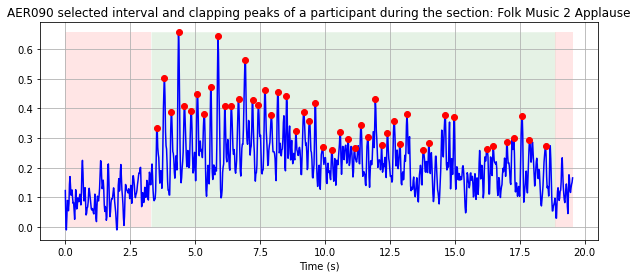

In [123]:

# in out pins
# Extends the window 10 timestamps at both ends
extend = 10 * 0.02
extend_ind = 0
if not (thr == 0):
    in_  = df_ev[df_ev[col]>thr][col].index.values[ 0] - extend
    out_ = df_ev[df_ev[col]>thr][col].index.values[-1] + extend
else:
    in_  = 0
    out_ = 0
df_ev.loc[:in_,col] = np.nan
df_ev.loc[out_:,col] = np.nan

# peaks
peak_index_list = find_peaks(df_ev[col].values,distance=10)[0]
# cut the peaks outside of the clapping range (not peaks because not audible in audio)
#peak_index_list=peak_index_list[peak_index_list>extend_ind]
peak_index_list=peak_index_list[peak_index_list<seg_len-extend_ind]

s_plot = df_ev[col].iloc[peak_index_list]
s_plot = s_plot[s_plot>thr]

# trim first and last peaks, + extend
# Extends the window 10 timestamps at both ends after trimming the
# signal based on first and last claps
if not s_plot.notna().sum() == 0:
    if s_plot.notna().sum()/df_motion.index[-1] <4:
        in_peak = s_plot.dropna().iloc[:1].index.values[0] - extend
        out_peak = s_plot.dropna().iloc[-1:].index.values[0] + extend
        in_peak_dt = pd.to_datetime(in_peak).strftime('%H:%M:%S.%f')
        out_peak_dt = pd.to_datetime(out_peak).strftime('%H:%M:%S.%f')
        df_ev.loc[:in_peak,col] = np.nan
        df_ev.loc[out_peak:,col] = np.nan

# write to df
df_trimmed[col] = df_ev[col].values
df_peaks.loc[:,col] = np.nan
df_peaks.loc[s_plot.index,col] = s_plot.values

#   # plot
plt.figure(figsize = [10,4])
i = -1 # participant idx
plt.plot(df_motion.loc[:,col], 'b-', df_peaks.loc[:,col], 'ro')

if df_peaks.loc[:,col].sum()>0:

    plt.fill_between(df_ev.index, df_peaks.loc[:,col].max(),
                   where=(df_trimmed.index>=in_)&(df_trimmed.index<=out_), fc='g', alpha=0.1)
    plt.fill_between(df_ev.index, df_peaks.loc[:,col].max(),
                   where=(df_trimmed.index<=in_)|(df_trimmed.index>=out_), fc='r', alpha=0.1)
    if thr == 0:
        plt.ylim(100)
        plt.axhline(thr_list[i], c='r', lw=2)
        plt.gcf().set_size_inches(24,4.8)

plt.title(col + ' selected interval and clapping peaks of a participant during the section: ' + ev_tag)
plt.xlabel('Time (s)')
plt.grid()
plt.show()

In [58]:
peak_index_list

array([214, 232, 250, 269, 287, 305, 322, 340, 359, 378, 396, 414, 432,
       451, 468, 486, 504, 522, 538, 555, 574, 591, 609, 627, 644])

In [60]:
peak_index_list = find_peaks(df_ev[col].values,distance=10)[0]
peak_index_list

array([214, 232, 250, 269, 287, 305, 322, 340, 359, 378, 396, 414, 432,
       451, 468, 486, 504, 522, 538, 555, 574, 591, 609, 627, 644])

<AxesSubplot:>

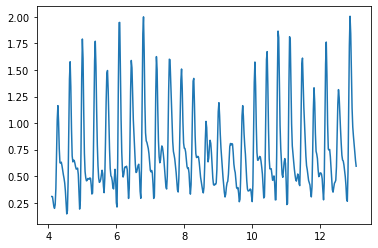

In [61]:
df_ev[col].plot()

In [69]:
out_

16.28

In [128]:
[15,(15**2+20**2)**(1/2),(15**2+25**2)**(1/2)]

[15, 25.0, 29.154759474226502]

In [147]:
from math import sinh, cosh, tanh, pi
cosh(13/29)

1.1021694937095978

In [134]:
[5,(5**2+20**2)**(1/2),(5**2+20.6**2)**(1/2)]

[5, 20.615528128088304, 21.19811312357777]

In [148]:
cosh(3/21)

1.0102214473226447

In [141]:
cos(0/21)

1.0